In [1]:
import pandas as pd
import numpy as np
import torch
from torch import optim
from datetime import timedelta
from torch.utils.data import DataLoader,TensorDataset
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import plotly.express as px
import plotly.graph_objects as go
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from TST import TimeSeriesTransformer
from LSTM import COVID_LSTM
from GRU import COVID_GRU

%matplotlib inline
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
from Utils import count_parameters, cumulative_to_daily, daily_to_cumulative

# Importing Dataset

In [6]:
state = 'VirginIslands'
df = pd.read_csv('us-vaccines.csv').drop(['Code'],1)
vaccines_daily = df[df['Entity']=='Virgin Islands']['people_vaccinated'].to_numpy().reshape(-1,1)


States to be worked on are: Northern Mariana Islands, Virgin Islands, Guam

Texas	, California, New York

Virginia

# Preprocessing Data

In [7]:
scaler = MinMaxScaler(feature_range=(-1.0,+1.0))
vaccines_cumulative_normalized = scaler.fit_transform(vaccines_daily)

In [8]:
def convert_to_slide_window(data,time_steps):
    X, y = [], []
    # Stride = 1
    # The (y) in our case is just the next timestep to compare with it
    for i in range(len(data) - time_steps):
        x = data[i:(i+time_steps)]
        X.append(x)
        y.append(data[i+time_steps])
    return X,y

In [9]:
window_size = 30

X,Y = convert_to_slide_window(vaccines_cumulative_normalized,window_size)
split = int(len(X) * 0.7)

X_train,y_train=X[:split],Y[:split]
X_test,y_test =X[split:],Y[split:]

# Cumulative + Non-Normalized
X_train, y_train = torch.FloatTensor(X_train).to(device), torch.FloatTensor(y_train).to(device)
X_test, y_test  = torch.FloatTensor(X_test).to(device), torch.FloatTensor(y_test).to(device)

# Load into DataLoader
train_loader = DataLoader(TensorDataset(X_train, y_train),batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), shuffle=False)

# Cumulative + Non-Normalized
y_test_inverse = scaler.inverse_transform(y_test.cpu().detach().numpy())
y_train_inverse = scaler.inverse_transform(y_train.cpu().detach().numpy())

# Non-Cumulative + Non-Normalized
y_test_daily_vaccines = cumulative_to_daily(y_test_inverse)


In [10]:
y_test_inverse.shape

(24, 1)

# TST Model

In [43]:
TST_model = TimeSeriesTransformer(n_features=1,d_model=512, n_heads=8, n_hidden=512, n_layers=8 ).to(device)
criterion=torch.nn.MSELoss()
# 0.00001 is the best LR for TST
optimizer = optim.Adam(TST_model.parameters(), lr=0.00001)
all_epochs_loss = TST_model.train_model(train_loader,criterion,optimizer,n_epochs = 100 )
torch.save(TST_model.state_dict(), 'Weights/model_TST_{}_Vaccine'.format(state))
# TST_model.load_state_dict(torch.load('Weights/model_TST_{}_Vaccine'.format(state)))

Epoch 1 Loss is 0.3284008726477623
Epoch 2 Loss is 0.13399985432624817
Epoch 3 Loss is 0.11114569753408432
Epoch 4 Loss is 0.1980685293674469
Epoch 5 Loss is 0.16737886890769005
Epoch 6 Loss is 0.09955370426177979
Epoch 7 Loss is 0.09136471897363663
Epoch 8 Loss is 0.08264754712581635
Epoch 9 Loss is 0.06386614963412285
Epoch 10 Loss is 0.10852653160691261
Epoch 11 Loss is 0.09991879388689995
Epoch 12 Loss is 0.04403240978717804
Epoch 13 Loss is 0.03777964785695076
Epoch 14 Loss is 0.03136255964636803
Epoch 15 Loss is 0.024080520495772362
Epoch 16 Loss is 0.02045571058988571
Epoch 17 Loss is 0.015543431742116809
Epoch 18 Loss is 0.0430503785610199
Epoch 19 Loss is 0.019062628038227558
Epoch 20 Loss is 0.0668148435652256
Epoch 21 Loss is 0.061256250366568565
Epoch 22 Loss is 0.0032390458072768524
Epoch 23 Loss is 0.00513766601216048
Epoch 24 Loss is 0.005308465857524425
Epoch 25 Loss is 0.03984989784657955
Epoch 26 Loss is 0.016920442460104823
Epoch 27 Loss is 0.05411345884203911
Epoch 

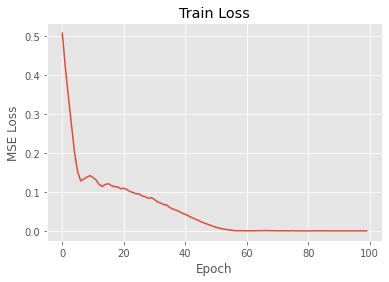

In [34]:
# Epoch 300 Loss is 0.0021550819316568473
fig, ax = plt.subplots()
plt.plot(all_epochs_loss)

ax.set_title('Train Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
plt.show()

In [35]:
def test_TST(model, X):
    model.eval()
    torch.cuda.empty_cache()
    S = X.shape[1] # Sequence Length
    src_mask = model.generate_square_subsequent_mask(S)
    predicted = model(X.permute(1,0,2),None,None).to(device) # [Batch Size, Sequence Length, n_features = 1]
    one_new_timesteps=predicted[-1,:,:] # [Batch Size, Sequence Length (Last time step), n_features = 1] -> [Batch Size,]
    print('TST: Test MSE Loss: ',criterion(one_new_timesteps,y_test).item())
    return one_new_timesteps
forecasted_TST = test_TST(TST_model, X=X_test)

TST: Test MSE Loss:  0.02152177318930626


In [36]:
X_train[-1].shape

torch.Size([30, 1])

In [37]:
def forecast_TST(model, X, forecast_len,n_seed):
    model.eval()
    datapoint = X.unsqueeze(1) # [S,B,E]
    torch.cuda.empty_cache()
    for t in range(forecast_len): 
        
        predicted = model(datapoint[-n_seed:,],None,None).to(device) # [S,B,E] 
        one_new_timestep=predicted[-1,:,:].unsqueeze(0) # [S,B,E]  -> Get the last predicted timestep
        datapoint = torch.cat((datapoint,one_new_timestep),0)  # add the forecasted timestep
        
    forecasted = datapoint.squeeze()[n_seed:,] # Skip the first (n)seed timesteps cuz are n_seed
    print('Test MSE Loss: ',criterion(forecasted,y_test))
    return forecasted

forecasted_once_TST = forecast_TST(TST_model,X=X_test[0],forecast_len=len(y_test),n_seed = window_size )

Test MSE Loss:  tensor(0.0339, device='cuda:0', grad_fn=<MseLossBackward>)


/rhome/yelnady/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning:

Using a target size (torch.Size([24, 1])) that is different to the input size (torch.Size([24])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



In [38]:
print("We used {} Parameters for the transformer model".format(count_parameters(TST_model)))

We used 797057 Parameters for the transformer model


In [39]:
forecasted_inverse_TST = scaler.inverse_transform(forecasted_TST.cpu().detach().numpy())
forecasted_daily_vaccines_TST  = cumulative_to_daily(forecasted_inverse_TST)

In [40]:
print('R2 Score for Vaccines',r2_score(y_test.cpu().detach().numpy(),forecasted_TST.cpu().detach().numpy()))
print('MAPE Score for Vaccines',mean_absolute_percentage_error(y_test.cpu().detach().numpy(),forecasted_TST.cpu().detach().numpy()))

R2 Score for Vaccines -2.5066920298360946
MAPE Score for Vaccines 0.15890692


# LSTM Model

In [19]:
LSTM_model = COVID_LSTM(n_hidden=256,n_features=1).to(device)
criterion=torch.nn.MSELoss()
optimizer = optim.Adam(LSTM_model.parameters(), lr=0.0001)
all_epochs_loss = LSTM_model.train_model(train_loader,criterion,optimizer,n_epochs = 100 )
torch.save(LSTM_model.state_dict(), 'Weights/model_LSTM_{}_Vaccine'.format(state))
# LSTM_model.load_state_dict(torch.load('Weights/model_LSTM_{}_Vaccine'.format(state)))

Epoch 1 Loss is 0.13245010748505592
Epoch 2 Loss is 0.12616942077875137
Epoch 3 Loss is 0.12952196598052979
Epoch 4 Loss is 0.12784073501825333
Epoch 5 Loss is 0.12714514136314392
Epoch 6 Loss is 0.12641946971416473
Epoch 7 Loss is 0.12992333993315697
Epoch 8 Loss is 0.12357333302497864
Epoch 9 Loss is 0.12576638907194138
Epoch 10 Loss is 0.12147767841815948
Epoch 11 Loss is 0.12292938679456711
Epoch 12 Loss is 0.1231025718152523
Epoch 13 Loss is 0.11872465908527374
Epoch 14 Loss is 0.1172592006623745
Epoch 15 Loss is 0.11436887830495834
Epoch 16 Loss is 0.11347832903265953
Epoch 17 Loss is 0.10495050251483917
Epoch 18 Loss is 0.10097198933362961
Epoch 19 Loss is 0.0961272232234478
Epoch 20 Loss is 0.08567585796117783
Epoch 21 Loss is 0.07427889108657837
Epoch 22 Loss is 0.06075357832014561
Epoch 23 Loss is 0.042360108345746994
Epoch 24 Loss is 0.022088635712862015
Epoch 25 Loss is 0.005897859460674226
Epoch 26 Loss is 0.0025434677954763174
Epoch 27 Loss is 0.012595904991030693
Epoch 2

In [20]:
def test_LSTM(model, X):
    model.eval()
    torch.cuda.empty_cache()
    predicted = model(X).to(device) # [Batch Size, Sequence Length, n_features = 1]
    one_new_timesteps=predicted[:,-1,:] # [Batch Size, Sequence Length (Last time step), n_features = 1] -> [Batch Size,]
    print('LSTM: Test MSE Loss: ',criterion(one_new_timesteps,y_test).item())
    return one_new_timesteps

forecasted_LSTM = test_LSTM(LSTM_model, X=X_test)

LSTM: Test MSE Loss:  0.013795023784041405


In [21]:
X_test.shape

torch.Size([24, 30, 1])

In [22]:
def forecast_LSTM(model, X, forecast_len,n_seed):
    model.eval()
    datapoint = X.unsqueeze(0) # [S,B,E]
    torch.cuda.empty_cache()
    for t in range(forecast_len): 
        
        predicted = model(datapoint[-n_seed:,]).to(device) # [B,S,E] 
        
        one_new_timestep=predicted[:,-1,:].unsqueeze(0) # [S,B,E]  -> Get the last predicted timestep
        datapoint = torch.cat((datapoint,one_new_timestep),1)  # add the forecasted timestep
    forecasted = datapoint.squeeze()[n_seed:,] # Skip the first (n)seed timesteps cuz are n_seed
    print('Test MSE Loss: ',criterion(forecasted,y_test))
    return forecasted

forecasted_once_LSTM = forecast_LSTM(LSTM_model,X=X_test[0],forecast_len=len(y_test),n_seed = window_size )

Test MSE Loss:  tensor(0.0249, device='cuda:0', grad_fn=<MseLossBackward>)


/rhome/yelnady/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning:

Using a target size (torch.Size([24, 1])) that is different to the input size (torch.Size([24])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



In [23]:
forecasted_inverse_LSTM = scaler.inverse_transform(forecasted_LSTM.cpu().detach().numpy())
forecasted_daily_vaccines_LSTM  = cumulative_to_daily(forecasted_inverse_LSTM)

In [24]:
print('R2 Score for Vaccines',r2_score(y_test_daily_vaccines,forecasted_daily_vaccines_LSTM))
print('MAPE Score for Vaccines',mean_absolute_percentage_error(y_test_daily_vaccines,forecasted_daily_vaccines_LSTM))

R2 Score for Vaccines 0.998307536884366
MAPE Score for Vaccines 2.4509528


# GRU Model

In [25]:
GRU_model = COVID_GRU(n_hidden=256,n_features=1).to(device)
criterion=torch.nn.MSELoss()
optimizer = optim.Adam(GRU_model.parameters(), lr=0.0001)
all_epochs_loss = GRU_model.train_model(train_loader,criterion,optimizer,n_epochs = 100 )
torch.save(GRU_model.state_dict(), 'Weights/model_GRU_{}_Vaccine'.format(state))
# GRU_model.load_state_dict(torch.load('Weights/model_GRU_{}_Vaccine'.format(state)))

Epoch 1 Loss is 0.14340593665838242
Epoch 2 Loss is 0.13521390780806541
Epoch 3 Loss is 0.13114923983812332
Epoch 4 Loss is 0.12071416899561882
Epoch 5 Loss is 0.12027814984321594
Epoch 6 Loss is 0.11369351670145988
Epoch 7 Loss is 0.10730603337287903
Epoch 8 Loss is 0.10273637622594833
Epoch 9 Loss is 0.0997748002409935
Epoch 10 Loss is 0.0921148955821991
Epoch 11 Loss is 0.08394074440002441
Epoch 12 Loss is 0.07452552020549774
Epoch 13 Loss is 0.06617579236626625
Epoch 14 Loss is 0.05499661713838577
Epoch 15 Loss is 0.045627182349562645
Epoch 16 Loss is 0.03321590647101402
Epoch 17 Loss is 0.021670110523700714
Epoch 18 Loss is 0.010994164273142815
Epoch 19 Loss is 0.0034389480715617537
Epoch 20 Loss is 0.0007910401618573815
Epoch 21 Loss is 0.002775910892523825
Epoch 22 Loss is 0.0070321038365364075
Epoch 23 Loss is 0.00877557136118412
Epoch 24 Loss is 0.006941878003999591
Epoch 25 Loss is 0.004099611891433597
Epoch 26 Loss is 0.0016971965960692614
Epoch 27 Loss is 0.0005493169883266

In [26]:
def test_GRU(model, X):
    model.eval()
    torch.cuda.empty_cache()
    predicted = model(X).to(device) # [Batch Size, Sequence Length, n_features = 1]
    one_new_timesteps=predicted[:,-1,:] # [Batch Size, Sequence Length (Last time step), n_features = 1] -> [Batch Size,]
    print('GRU: Test MSE Loss: ',criterion(one_new_timesteps,y_test).item())
    return one_new_timesteps

forecasted_GRU = test_GRU(GRU_model, X=X_test)

GRU: Test MSE Loss:  0.012565425597131252


In [27]:
X_test.shape

torch.Size([24, 30, 1])

In [28]:
def forecast_GRU(model, X, forecast_len,n_seed):
    model.eval()
    datapoint = X.unsqueeze(0) # [S,B,E]
    torch.cuda.empty_cache()
    for t in range(forecast_len): 
        
        predicted = model(datapoint[-n_seed:,]).to(device) # [B,S,E] 
        
        one_new_timestep=predicted[:,-1,:].unsqueeze(0) # [S,B,E]  -> Get the last predicted timestep
        datapoint = torch.cat((datapoint,one_new_timestep),1)  # add the forecasted timestep
    forecasted = datapoint.squeeze()[n_seed:,] # Skip the first (n)seed timesteps cuz are n_seed
    print('Test MSE Loss: ',criterion(forecasted,y_test))
    return forecasted

forecasted_once_GRU = forecast_GRU(GRU_model,X=X_test[0],forecast_len=len(y_test),n_seed = window_size )

Test MSE Loss:  tensor(0.0285, device='cuda:0', grad_fn=<MseLossBackward>)


/rhome/yelnady/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning:

Using a target size (torch.Size([24, 1])) that is different to the input size (torch.Size([24])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



In [29]:
forecasted_inverse_GRU = scaler.inverse_transform(forecasted_GRU.cpu().detach().numpy())
forecasted_daily_vaccines_GRU  = cumulative_to_daily(forecasted_inverse_GRU)

In [30]:
print('R2 Score for Vaccines',r2_score(y_test_daily_vaccines,forecasted_daily_vaccines_GRU))
print('MAPE Score for Vaccines',mean_absolute_percentage_error(y_test_daily_vaccines,forecasted_daily_vaccines_GRU))

R2 Score for Vaccines 0.9982733896892256
MAPE Score for Vaccines 2.5007765


# Plots

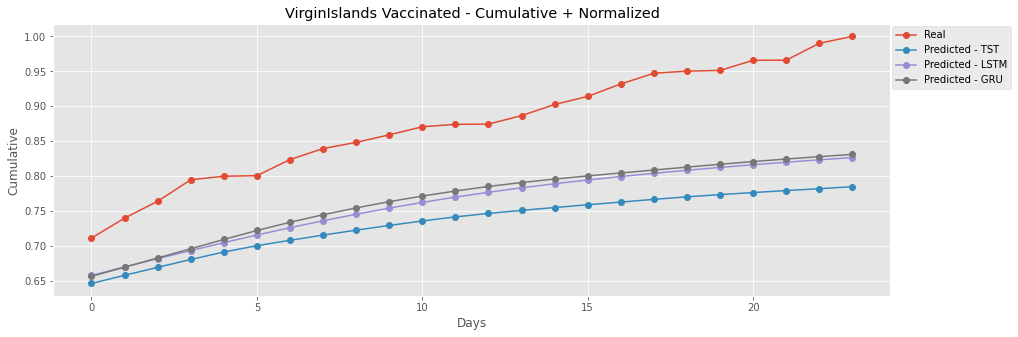

In [42]:
fig, ax = plt.subplots()
# ax.set_ylim([0.0,1.1])

plt.plot(y_test[:,0].cpu().detach().numpy(),label='Real',marker='o')
plt.plot(forecasted_TST[:,0].cpu().detach().numpy(),label='Predicted - TST',marker='o')
plt.plot(forecasted_LSTM[:,0].cpu().detach().numpy(),label='Predicted - LSTM',marker='o')
plt.plot(forecasted_GRU[:,0].cpu().detach().numpy(),label='Predicted - GRU',marker='o')

# plt.plot(forecasted_once_TST[:,0].cpu().detach().numpy(),label='Forecast Function - TST',marker='o')
fig.set_size_inches(15, 5)
ax.set_title('{} Vaccinated - Cumulative + Normalized'.format(state))
ax.set_xlabel('Days')
ax.set_ylabel('Cumulative')
leg = ax.legend(bbox_to_anchor=(1.15, 1.01))
plt.show()

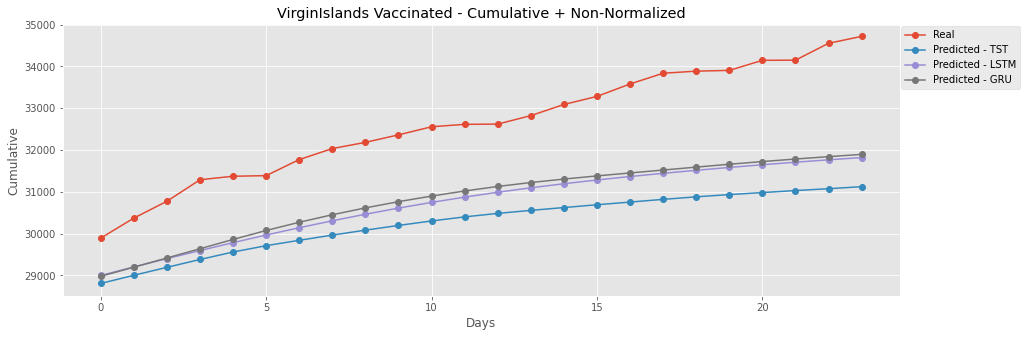

In [41]:
fig, ax = plt.subplots()

plt.plot(y_test_inverse[:,0],label='Real',marker='o')
plt.plot(forecasted_inverse_TST[:,0],label='Predicted - TST',marker='o')
plt.plot(forecasted_inverse_LSTM[:,0],label='Predicted - LSTM',marker='o')
plt.plot(forecasted_inverse_GRU[:,0],label='Predicted - GRU',marker='o')

fig.set_size_inches(15, 5)
ax.set_title('{} Vaccinated - Cumulative + Non-Normalized'.format(state))
ax.set_xlabel('Days')
ax.set_ylabel('Cumulative')
leg = ax.legend(bbox_to_anchor=(1.15, 1.01))
plt.show()